In [26]:
import sys
sys.path.append("..")
import Essentials

In [27]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

In [28]:
data_archive = np.load('../Data_Average.npz', allow_pickle=True)

In [29]:
def prepare_Y(y):
    timestamp = y[:, 1]   
    y = y[:, 0].reshape(len(y), 1)
    y = y.astype(np.float64)

    return y, timestamp

In [30]:
all_X_1 = data_archive['all_X_1']
all_Y_1 = data_archive['all_Y_1']

all_X_2 = data_archive['all_X_2']
all_Y_2 = data_archive['all_Y_2']

all_X_3 = data_archive['all_X_3']
all_Y_3 = data_archive['all_Y_3']

x_summer_half_2 = data_archive['x_summer_half_2']
y_summer_half_2 = data_archive['y_summer_half_2']
x_winter_half_2 = data_archive['x_winter_half_2']
y_winter_half_2 = data_archive['y_winter_half_2']

x_summer_half_3 = data_archive['x_summer_half_3']
y_summer_half_3 = data_archive['y_summer_half_3']
x_winter_half_3 = data_archive['x_winter_half_3']
y_winter_half_3 = data_archive['y_winter_half_3']

In [31]:
all_X_1.shape

(129, 96)

In [32]:
x_train, x_test, y_train, y_test = train_test_split(all_X_1, all_Y_1, test_size=0.25, random_state=42)

In [33]:
x_train.shape

(96, 96)

In [34]:
y_train, timestamp_train = prepare_Y(y_train)

In [35]:
y_test, timestamp_test = prepare_Y(y_test)

In [36]:
x_train_winter, x_test_winter, y_train_winter, y_test_winter = train_test_split(x_winter_half_3, y_winter_half_3, test_size=0.2, random_state=42)

In [37]:
x_train_summer, x_test_summer, y_train_summer, y_test_summer = train_test_split(x_summer_half_3, y_summer_half_3, test_size=0.2, random_state=42)

In [38]:
y_train_summer, timestamp_train_summer = prepare_Y(y_train_summer)

In [39]:
y_train_winter, timestamp_train_winter = prepare_Y(y_train_winter)

In [40]:
y_test_summer, timestamp_test_summer = prepare_Y(y_test_summer)

In [41]:
y_test_winter, timestamp_test_winter = prepare_Y(y_test_winter)

In [42]:
class XGBoost(Essentials.SoftSensor):
    def __init__(self,name, x_train, y_train):
        super().__init__(name)
        self.model = xgb.XGBRegressor()
        self.x_scaler = StandardScaler() 
        self.y_scaler = StandardScaler()
        self.fit_scaler(x_train, y_train)
        self.RandomizedSearchCV(x_train, y_train)
        self.train(x_train, y_train)
        self.set_model(self.model)

    def preprocessing(self, x):
        try:
            return self.x_scaler.transform(x)
        except:
            try:
               return self.y_scaler.transform(x)
            except BaseException as err:
                print("Ошибка скейлера")
                raise err
            
    def postprocessing(self, x):
        try:
            return self.x_scaler.inverse_transform(x)
        except:
            try:
               return self.y_scaler.inverse_transform(x)
            except BaseException as err:
                print("Ошибка скейлера")
                raise err

    def fit_scaler(self, x_train, y_train):
        self.x_scaler.fit(x_train)
        self.y_scaler.fit(y_train)

    def evaluate_model(self, x):
        predictions = self.get_model().predict(x)
        return predictions.reshape(-1,1)
    
    def RandomizedSearchCV(self,x_train,y_train):
        x_train_scaled = self.preprocessing(x_train) 
        y_train_scaled = self.preprocessing(y_train) 
        param_distributions = {
            'n_estimators': np.arange(50, 201, 50),
            'learning_rate': np.linspace(0.01, 0.1, num=10),
            'max_depth': np.arange(3, 11),
            'min_child_weight': np.arange(1, 6),
            'subsample': np.linspace(0.5, 1.0, num=6),
            'colsample_bytree': np.linspace(0.5, 1.0, num=6),
            'gamma': np.linspace(0, 0.5, num=6),
            'reg_alpha': np.linspace(0, 1, num=11),
            'reg_lambda': np.linspace(1, 5, num=5)
        }

        self.random_search = RandomizedSearchCV(
            estimator=self.model,
            param_distributions=param_distributions,
            n_iter=100,  # Количество итераций поиска. Увеличьте или уменьшите в зависимости от вычислительных ресурсов.
            scoring='r2',
            cv=3,  # Кросс-валидация по 3 блокам
            verbose=1,
            random_state=42,
            n_jobs=-1  # Используйте все доступные ядра
        )
        self.random_search.fit(x_train_scaled, y_train_scaled)
    
    def train(self, x_train, y_train):
        x_train_scaled = self.preprocessing(x_train) 
        y_train_scaled = self.preprocessing(y_train)
        self.model = xgb.XGBRegressor(**self.random_search.best_params_)
        self.model.fit(x_train_scaled,y_train_scaled)

    def __str__(self):
        feature_importance = self.get_model().feature_importances_
        return f"Важность признаков: = {feature_importance.reshape(-1, 1)}"

In [43]:
XGBoost_test = XGBoost("XGBoost",x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [44]:
metric = Essentials.R2Metric()

In [45]:
print(XGBoost_test)

Важность признаков: = [[0.00907928]
 [0.03275635]
 [0.01297752]
 [0.00266472]
 [0.00359391]
 [0.00298865]
 [0.00202923]
 [0.0062208 ]
 [0.01017772]
 [0.0106171 ]
 [0.00189295]
 [0.00929877]
 [0.11725441]
 [0.00242314]
 [0.00467263]
 [0.06056397]
 [0.06784752]
 [0.00694298]
 [0.01169669]
 [0.00537646]
 [0.00647445]
 [0.0191001 ]
 [0.01925264]
 [0.00262054]
 [0.01497181]
 [0.00387856]
 [0.06242655]
 [0.0061151 ]
 [0.03272938]
 [0.01088686]
 [0.00663373]
 [0.00194005]
 [0.00145037]
 [0.00144346]
 [0.00983254]
 [0.0019308 ]
 [0.00206159]
 [0.00441119]
 [0.00781184]
 [0.01863767]
 [0.00872245]
 [0.00262064]
 [0.01333803]
 [0.01815321]
 [0.0051727 ]
 [0.00047932]
 [0.00684148]
 [0.0071668 ]
 [0.0047571 ]
 [0.00797653]
 [0.00720264]
 [0.00395984]
 [0.01398522]
 [0.        ]
 [0.00133865]
 [0.00378926]
 [0.00224865]
 [0.02314395]
 [0.03434385]
 [0.00015545]
 [0.0030214 ]
 [0.04028127]
 [0.0072375 ]
 [0.00254618]
 [0.00387584]
 [0.00088994]
 [0.00880851]
 [0.020676  ]
 [0.0048939 ]
 [0.00168717

In [46]:
XGBoost_test.test(x_test, y_test, metric)

(array([[54.98992 ],
        [58.800285],
        [56.609512],
        [57.448917],
        [59.946106],
        [54.832035],
        [59.79351 ],
        [51.34802 ],
        [58.906956],
        [58.62024 ],
        [55.184006],
        [58.542442],
        [58.591774],
        [52.620407],
        [52.215702],
        [51.7686  ],
        [59.83779 ],
        [58.21873 ],
        [55.070747],
        [56.448353],
        [56.510124],
        [54.793568],
        [59.46846 ],
        [57.089535],
        [57.585625],
        [60.34547 ],
        [58.90138 ],
        [58.954803],
        [62.16038 ],
        [53.435883],
        [56.9908  ],
        [58.82209 ],
        [57.71151 ]], dtype=float32),
 0.6474440591645381)

In [47]:
XGBoost_test_visual_train = Essentials.Visualizer(x_train, y_train, timestamp_train, [metric], 'XGBoost SoftSensor R2 metric on Train')

         Coefficient of determination
XGBoost                      0.973446


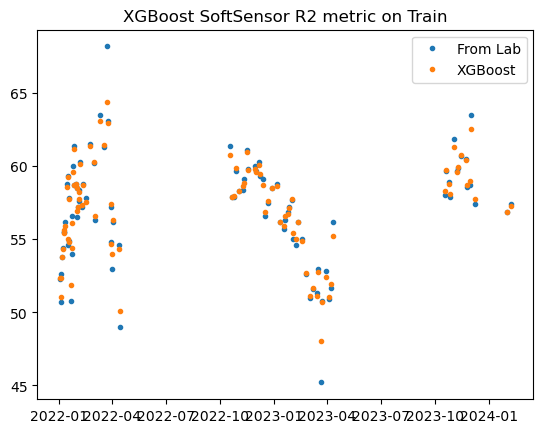

In [48]:
XGBoost_test_visual_train.visualize([XGBoost_test])

In [49]:
XGBoost_test_visual_test = Essentials.Visualizer(x_test, y_test, timestamp_test, [metric], 'XGBoost SoftSensor R2 metric on Test')

         Coefficient of determination
XGBoost                      0.647444


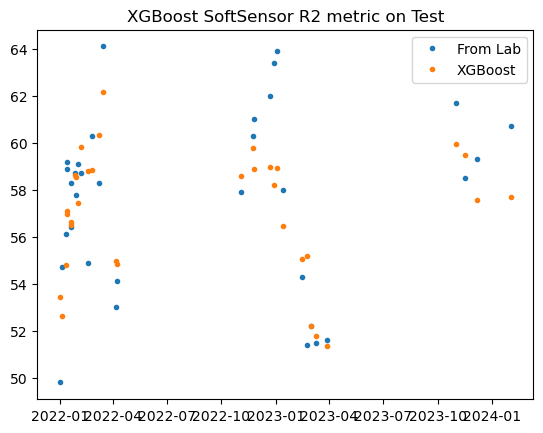

In [50]:
XGBoost_test_visual_test.visualize([XGBoost_test])